# Camera installation
For the camera to work properly, make sure:
1. Numpy v1 is installed: `pip3 install numpy==1.26.4`
2. OpenCV is installed as system package `sudo apt install python3-opencv`
3. Python venv is created with access to system packages `python3 -m venv <venv-path> --system-site-packages`
4. Install Ultralytics wihout dependencies: `pip3 install ultralytics --no-deps` (otherwise it will install Numpy 2.x and the opencv python package, breaking the camera)
5. Install dependencies for ultralytics: `pip3 install matplotlib pandas pyyaml requests tqdm psutil py-cpuinfo seaborn ultralytics-thop

In [2]:
# Import requirements
import cv2
from IPython.display import display, Image, clear_output
import time
from ultralytics import YOLO

In [4]:
# Prepare gsteamer pipeline for Jetson camera
def gstreamer_pipeline(
    capture_width=640,
    capture_height=480,
    framerate=30,
    flip_method=2,
):
    return (
        "nvarguscamerasrc ! "
        "video/x-raw(memory:NVMM), "
        "width=(int)%d, height=(int)%d, "
        "format=(string)NV12, framerate=(fraction)%d/1 ! "
        "nvvidconv flip-method=%d ! "
        "video/x-raw, width=(int)%d, height=(int)%d, format=(string)BGRx ! "
        "videoconvert ! "
        "video/x-raw, format=(string)BGR ! appsink"
        % (capture_width, capture_height, framerate, flip_method, capture_width, capture_height)
    )

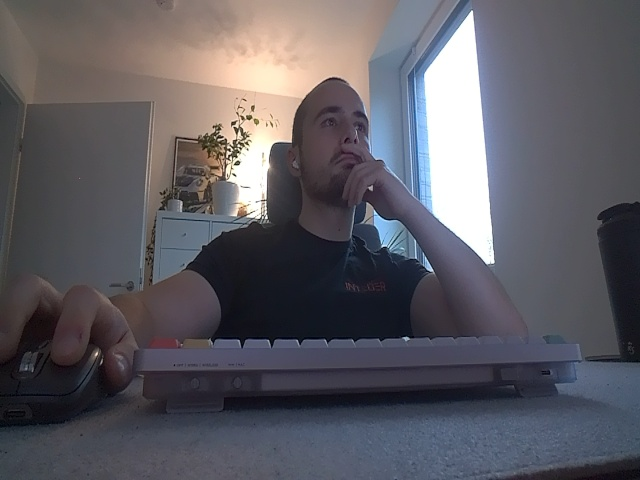

Stopped
GST_ARGUS: Cleaning up
CONSUMER: Done Success
GST_ARGUS: Done Success
Camera released


In [42]:
# Test if camera stream is working
cap = cv2.VideoCapture(gstreamer_pipeline(), cv2.CAP_GSTREAMER)

if not cap.isOpened():
    print("ERROR: Could not open camera")
else:
    print("Camera opened! Streaming... (stop with the stop button)")
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                print("Failed to read frame")
                break
            
            _, jpeg = cv2.imencode('.jpg', frame)
            clear_output(wait=True)
            display(Image(data=jpeg.tobytes()))
            
            time.sleep(0.05)
            
    except KeyboardInterrupt:
        print("Stopped")
    finally:
        cap.release()
        print("Camera released")

In [ ]:
# Detection

In [ ]:
# Image Segmentation

In [ ]:
# Classification

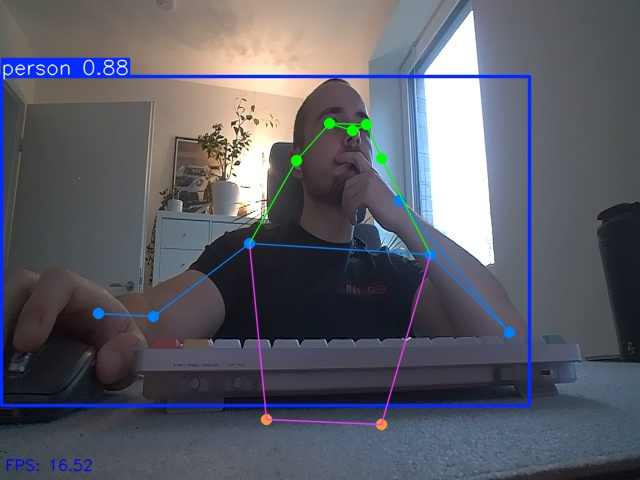

GST_ARGUS: Cleaning up
CONSUMER: Done Success
GST_ARGUS: Done Success


In [43]:
# Pose estimation

# Load YOLO model and start video capture
model = YOLO("yolo11s-pose.pt")
cap = cv2.VideoCapture(gstreamer_pipeline(), cv2.CAP_GSTREAMER)

# Prepare for FPS calculation
freq = cv2.getTickFrequency()

try:
    while True:
        # Get start tick for FPS calculation
        t1 = cv2.getTickCount()

        # Read frame
        ret, frame = cap.read()
        if not ret:
            break
        
        # Run detection
        results = model(frame, verbose=False)
        annotated = results[0].plot()
        
        # Add FPS to frame
        t2 = cv2.getTickCount()
        time1 = (t2-t1)/freq
        frame_rate_calc = 1/time1
        annotated_with_fps = cv2.putText(annotated, # Image to draw text on
                                         f'FPS: {frame_rate_calc:.2f}', # Text to display
                                         (5, 470), # Position (bottom-left corner)
                                         cv2.FONT_HERSHEY_SIMPLEX, # Font
                                         0.5, # Font scale
                                         (255, 0, 0), # Font color
                                         1, # Font weight (thickness)
                                         cv2.LINE_AA) # Line type

        # Convert to JPEG bytes for display
        _, jpeg = cv2.imencode('.jpg', annotated_with_fps)
        
        # Display in notebook
        clear_output(wait=True)

        display(Image(data=jpeg.tobytes()))
        
except KeyboardInterrupt:
    pass
finally:
    cap.release()

In [ ]:
# OBB